# Simple decision rules give high performance for detecting social bots on benchmark datasets

Analysis of benchmark datasets for bot detection.

## Setup

In [197]:
import bson
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import pandas as pd
import time

import importlib

In [90]:
from data_accessor import load_twibot, load_bot_repo_dataset, load_cresci, load_cresci2017, load_cresci2015, load_caverlee, load_emd, load_pan19, load_cresci2017_tweets, load_cresci2015_tweets, load_midterm, load_gilani_derived_bands, load_yang, load_yang_tweets, load_cresci_stock_tweets, tweets_to_countvectorized_df
from preprocess import drop_and_one_hot, extract_users, load_json, preprocess_users, COLUMNS_TO_DROP, DUMMY_COLUMNS
from fit_and_score import fit, score, fit_and_score, kfold_cv, analyze_bot_repo_dataset, analyze_bot_repo_dataset_full, train_test_fit_and_score, nonnumeric, mdi_feature_importance, permutation_feature_importance, plot_metrics, calculate_accuracy


In [3]:
PROJ_PATH = "/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection"


## Load datasets and calculate scores

In [ ]:
kantepe_path = PROJ_PATH + "/data/kantepe-2017/tweet.bson"

with open(kantepe_path,'rb') as f:
    data = bson.decode_all(f.read())
    kantepe = pd.DataFrame(data)

In [18]:
kantepe.head()

,Unnamed: 0,_id,currentTTs,legacyTTs,freshTTs,counts,timeStamp
0,0,58bfd6d350837b5591a2d71d,"['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['#8MartDünyaKadınlarGünü', '#PKKlılarHayırDiy...","['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","[{'_1': '#İyiliğinAdı', '_2': 0}, {'_1': ""Resm...",1488967379682
1,1,58bfdbf350837b59a3954ed0,"['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['#8MartDünyaKadınlarGünü', '#PKKlılarHayırDiy...","['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","[{'_1': '#İyiliğinAdı', '_2': 0}, {'_1': ""Resm...",1488968691394
2,2,58bfde4c50837b59a3955082,"['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['""kadın""', 'türkan elçi']","[{'_1': '#kadıni̇sterse', '_2': 1}, {'_1': 'se...",1488969292116
3,3,58bfe0a450837b59a39551b4,"['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['anadolu üniversitesi', 'ocak', 'dick advocaat']","[{'_1': '#kadıni̇sterse', '_2': 0}, {'_1': 'se...",1488969892455
4,4,58bfe2fb50837b59a39552be,"['seda sayan', 'i̇stanbul-bursa-i̇zmir', '#i̇s...","['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['i̇stanbul-bursa-i̇zmir', '#ülkücülerevetdiyor']","[{'_1': '#kadıni̇sterse', '_2': 0}, {'_1': 'se...",1488970491929
...,...,...,...,...,...,...,...
416,416,58c82f1450837b4c97c06c12,"['i̇stanbul film festivali', 'tugay kerimoğlu'...","['i̇stanbul film festivali', 'tugay kerimoğlu'...","['#tatlımtatlım', '#referandumi̇çinevet']","[{'_1': 'i̇stanbul film festivali', '_2': 4}, ...",1489514260842
417,417,58c8316c50837b4c97c1fccf,"['i̇stanbul film festivali', 'tugay kerimoğlu'...","['i̇stanbul film festivali', 'tugay kerimoğlu'...","['#kızımolmadan', 'srebrenîtsayê', 'hıncal ulu...","[{'_1': 'i̇stanbul film festivali', '_2': 4}, ...",1489514860868
418,418,58c833c450837b4c97c37d5f,"['i̇stanbul film festivali', 'tugay kerimoğlu'...","['i̇stanbul film festivali', 'tugay kerimoğlu'...","['fortisbet yüksekoran500tlbonus', 'gençlerbir...","[{'_1': 'i̇stanbul film festivali', '_2': 2}, ...",1489515460850
419,419,58c8361c50837b4c97c510c6,"['i̇stanbul film festivali', 'tugay kerimoğlu'...","['i̇stanbul film festivali', 'tugay kerimoğlu'...","['#tercihimizevetçünkü', 'gazimagusa ülküocakl...","[{'_1': 'i̇stanbul film festivali', '_2': 2}, ...",1489516060867


## Profile data

In [4]:
# Twibot
twibot_df, twibot_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json")
twibot_test, twibot_one_hot_test, twibot_labels_test = load_twibot(PROJ_PATH + "/data/Twibot-20/test.json")
#twibot_validate, twibot_one_hot_validate, twibot_labels_validate = load_twibot(PROJ_PATH + "/data/Twibot-20/dev.json")
shared_columns = np.intersect1d(twibot_one_hot.columns, twibot_one_hot_test.columns) # Since we want to check on test set, just use common columns between train/test.
twibot_scores = []
for i in range(1, 6):
    dt_clf = fit(twibot_one_hot[shared_columns], twibot_labels, depth=i)
    scr = score(dt_clf, twibot_one_hot_test[shared_columns], twibot_labels_test, silent=True)
    twibot_scores.append(scr)
    
# botometer-feedback
bf, bf_one_hot, bf_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botometer-feedback-2019_tweets.json", PROJ_PATH + "/data/botometer-feedback-2019.tsv")
botometer_feedback_scores = analyze_bot_repo_dataset(bf_one_hot, bf_labels, silent=True)

#rtbust
rtbust, rtbust_one_hot, rtbust_labels = load_bot_repo_dataset(PROJ_PATH + "/data/cresci-rtbust-2019_tweets.json", PROJ_PATH + "/data/cresci-rtbust-2019.tsv")
rtbust_scores = analyze_bot_repo_dataset(rtbust_one_hot, rtbust_labels, silent=True)

#gilani-2017
gilani, gilani_one_hot, gilani_labels = load_bot_repo_dataset(PROJ_PATH + "/data/gilani-2017_tweets.json", PROJ_PATH + "/data/gilani-2017.tsv")
gilani_scores = analyze_bot_repo_dataset(gilani_one_hot, gilani_labels, silent=True)

#gilani-2017 with derived features from orginal paper
gilani_derived_dfs, gilani_derived_labels = load_gilani_derived_bands(PROJ_PATH + f"/data/gilani_derived/classification_processed/")
gilani_derived_scores = [analyze_bot_repo_dataset(gilani_derived_df, gilani_derived_label, silent=True) for gilani_derived_df, gilani_derived_label in zip(gilani_derived_dfs, gilani_derived_labels)]
gilani_derived_scores_avg = [[sum([strat[depth_ind][scr_ind] for strat in gilani_derived_scores])/4 for scr_ind in range(4)] for depth_ind in range(5)]

#cresci-2017
cresci2017, cresci2017_one_hot, cresci2017_labels = load_cresci2017(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv")
cresci2017_scores = analyze_bot_repo_dataset(cresci2017_one_hot, cresci2017_labels, silent=True)

#cresci-2015
cresci2015, cresci2015_one_hot, cresci2015_labels = load_cresci2015(PROJ_PATH + "/data/cresci-2015/{}/users.csv")
cresci2015_scores = analyze_bot_repo_dataset(cresci2015_one_hot, cresci2015_labels, silent=True)

#caverlee-2011
caverlee2011, caverlee2011_labels = load_caverlee(PROJ_PATH + "/data/social_honeypot_icwsm_2011/")
caverlee2011_scores = analyze_bot_repo_dataset(caverlee2011, caverlee2011_labels, silent=True)

#cresci-stock-2018
cresci_stock, cresci_stock_one_hot, cresci_stock_labels = load_bot_repo_dataset(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv")
cresci_stock_scores = analyze_bot_repo_dataset(cresci_stock_one_hot, cresci_stock_labels, silent=True)

Starting kfold_cv at 08/09/22 20:15:32
Finished kfold_cv at 1660090532.759422. Execution time: 0.09840798377990723 s
Starting kfold_cv at 08/09/22 20:15:32
Finished kfold_cv at 1660090532.8600066. Execution time: 0.1003568172454834 s
Starting kfold_cv at 08/09/22 20:15:32
Finished kfold_cv at 1660090532.964979. Execution time: 0.10477066040039062 s
Starting kfold_cv at 08/09/22 20:15:32
Finished kfold_cv at 1660090533.0708952. Execution time: 0.10566377639770508 s
Starting kfold_cv at 08/09/22 20:15:33
Finished kfold_cv at 1660090533.1804352. Execution time: 0.1093597412109375 s
Starting kfold_cv at 08/09/22 20:15:33
Finished kfold_cv at 1660090533.3189268. Execution time: 0.08250284194946289 s
Starting kfold_cv at 08/09/22 20:15:33
Finished kfold_cv at 1660090533.404421. Execution time: 0.08531546592712402 s
Starting kfold_cv at 08/09/22 20:15:33
Finished kfold_cv at 1660090533.490324. Execution time: 0.08565330505371094 s
Starting kfold_cv at 08/09/22 20:15:33
Finished kfold_cv at 16

In [185]:
midterm, midterm_one_hot, midterm_labels = load_midterm(PROJ_PATH + "/data/midterm-2018/midterm-2018_processed_user_objects.json", PROJ_PATH + "/data/midterm-2018/midterm-2018.tsv")
midterm_scores = analyze_bot_repo_dataset(midterm_one_hot, midterm_labels, kfold=False, silent=True)

In [6]:
yang, yang_one_hot, yang_labels = load_yang(PROJ_PATH + "/data/yang-2013/")
yang_scores = analyze_bot_repo_dataset(yang_one_hot, yang_labels)

Starting kfold_cv at 08/09/22 20:21:59
Finished kfold_cv at 1660090940.7652917. Execution time: 21.335951328277588 s
Starting kfold_cv at 08/09/22 20:22:20
Finished kfold_cv at 1660090965.3891118. Execution time: 24.623552799224854 s
Starting kfold_cv at 08/09/22 20:22:45
Finished kfold_cv at 1660090993.0157702. Execution time: 27.626391410827637 s
Starting kfold_cv at 08/09/22 20:23:13
Finished kfold_cv at 1660091023.2021017. Execution time: 30.186065435409546 s
Starting kfold_cv at 08/09/22 20:23:43
Finished kfold_cv at 1660091055.780836. Execution time: 32.5784707069397 s


In [186]:
yang_scores

[[0.9150932801698847,
  0.5322043087315544,
  0.5930396348293554,
  0.5590558668395839],
 [0.9511833087957203,
  0.8441737583922458,
  0.562672510055483,
  0.6743921369521659],
 [0.9527264060300459,
  0.8799727036512148,
  0.5594216968914335,
  0.6798134859940549],
 [0.9553619856514963,
  0.880224308526687,
  0.591296614745677,
  0.7058863267452545],
 [0.9572718643372072,
  0.890159853401219,
  0.6053029295749679,
  0.7198425566102031]]

## Tweets data

In [7]:
yang_tweets, yang_tweets_labels = load_yang_tweets(PROJ_PATH + "/data/yang-2013/")
yang_tweets_scores = analyze_bot_repo_dataset(yang_tweets, yang_tweets_labels)


Starting kfold_cv at 08/09/22 20:25:49
Finished kfold_cv at 1660091172.2099516. Execution time: 22.828202724456787 s
Starting kfold_cv at 08/09/22 20:26:12
Finished kfold_cv at 1660091207.3326867. Execution time: 35.12261438369751 s
Starting kfold_cv at 08/09/22 20:26:47
Finished kfold_cv at 1660091254.3198838. Execution time: 46.9870924949646 s
Starting kfold_cv at 08/09/22 20:27:34
Finished kfold_cv at 1660091313.2051392. Execution time: 58.88514733314514 s
Starting kfold_cv at 08/09/22 20:28:33
Finished kfold_cv at 1660091383.6093373. Execution time: 70.40325951576233 s


In [8]:
pan19_df, pan19_labels = load_pan19(PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/{}.xml", PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/truth.txt")
pan19_scores = analyze_bot_repo_dataset(pan19_df, pan19_labels)


Starting kfold_cv at 08/09/22 20:29:56
Finished kfold_cv at 1660091401.577421. Execution time: 5.073747158050537 s
Starting kfold_cv at 08/09/22 20:30:01
Finished kfold_cv at 1660091408.7702374. Execution time: 7.192466974258423 s
Starting kfold_cv at 08/09/22 20:30:08
Finished kfold_cv at 1660091418.0931165. Execution time: 9.322538137435913 s
Starting kfold_cv at 08/09/22 20:30:18
Finished kfold_cv at 1660091429.518009. Execution time: 11.424563646316528 s
Starting kfold_cv at 08/09/22 20:30:29
Finished kfold_cv at 1660091442.8449633. Execution time: 13.326091051101685 s


In [9]:
cresci2017_tweets, cresci2017_tweets_labels = load_cresci2017_tweets(PROJ_PATH + "/data/cresci-2017/{}.csv/tweets.csv")
cresci2017_tweets_scores = analyze_bot_repo_dataset(cresci2017_tweets, cresci2017_tweets_labels, kfold=False, silent=True)


/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (7,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Starting kfold_cv at 08/09/22 20:32:26
Finished kfold_cv at 1660091598.4792325. Execution time: 51.6725914478302 s
Starting kfold_cv at 08/09/22 20:33:18
Finished kfold_cv at 1660091678.2457283. Execution time: 79.76609754562378 s
Starting kfold_cv at 08/09/22 20:34:38
Finished kfold_cv at 1660091784.7035055. Execution time: 106.45691847801208 s
Starting kfold_cv at 08/09/22 20:36:24
Finished kfold_cv at 1660091917.4047744. Execution time: 132.7004075050354 s
Starting kfold_cv at 08/09/22 20:38:37
Finished kfold_cv at 1660092076.5746665. Execution time: 159.16902923583984 s


In [12]:
cresci2015_tweets, cresci2015_tweets_labels = load_cresci2015_tweets(PROJ_PATH + "/data/cresci-2015/{}/tweets.csv")
cresci2015_tweets_scores = analyze_bot_repo_dataset(cresci2015_tweets, cresci2015_labels)


Starting kfold_cv at 08/09/22 20:45:53
Finished kfold_cv at 1660092377.0276. Execution time: 23.43911361694336 s
Starting kfold_cv at 08/09/22 20:46:17
Finished kfold_cv at 1660092411.9043682. Execution time: 34.87642812728882 s
Starting kfold_cv at 08/09/22 20:46:51
Finished kfold_cv at 1660092454.3603797. Execution time: 42.45515513420105 s
Starting kfold_cv at 08/09/22 20:47:34
Finished kfold_cv at 1660092502.990393. Execution time: 48.62920618057251 s
Starting kfold_cv at 08/09/22 20:48:22
Finished kfold_cv at 1660092555.2861538. Execution time: 52.294917345047 s


In [14]:
cresci_stock_tweets, cresci_stock_tweets_labels = load_cresci_stock_tweets(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv", PROJ_PATH + "/data/golbeck/tweets/{}_tweets.csv")
cresci_stock_tweets_scores = analyze_bot_repo_dataset(cresci_stock_tweets, cresci_stock_tweets_labels)


KeyboardInterrupt: 

## Only account ids

In [6]:
varol = np.loadtxt(PROJ_PATH + "/data/varol-2017.dat", unpack=True)
kaiser = pyreadr.read_r(PROJ_PATH + '/data/kaiser/data_botometer.RData')['data_botometer']


# Train on one, test on another

In [38]:
datasets = [twibot_one_hot, bf_one_hot, rtbust_one_hot, gilani_one_hot, cresci2017_one_hot, cresci2015_one_hot, cresci_stock_one_hot, yang_one_hot]
labels = [twibot_labels, bf_labels, rtbust_labels, gilani_labels, cresci2017_labels, cresci2015_labels, cresci_stock_labels, yang_labels]

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_dataset_name(df):
    return namestr(df, globals())[0]

def train_on_one_test_on_another(train_on, train_on_labels, test_on, test_on_labels, silent=True):
    cols = ([e for e in list(train_on) if e in list(test_on)])
    #print(cols)
    scores = {
        'train_on': get_dataset_name(train_on),
        'test_on': get_dataset_name(test_on),
    }
    for i in range(1,6):
        clf, *_ = fit_and_score(train_on[cols], train_on_labels, silent=True)

        a,p,r,f = (score(clf, test_on[cols], test_on_labels, silent=True))
        #prop_bots = sum(test_on_labels)/len(test_on_labels)
        
        scores = {
            **scores, 
            f'a{i}': a,
            f'p{i}': p,
            f'r{i}': r,
            f'f{i}': f
        }
    if not silent:
        print(f"trained on: {get_dataset_name(train_on)}, tested on: {get_dataset_name(test_on)}, acc: {a:.2}, prec: {p:.2}, recall: {r:.2}, f1: {f:.2}, test bot freq: {np.round_(prop_bots,2)}")

    return scores
            

In [39]:
rows = []

for train_on, train_on_labels in zip(datasets,labels):
    for test_on, test_on_labels in zip(datasets,labels):
        rows.append(train_on_one_test_on_another(train_on, train_on_labels, test_on, test_on_labels))
        
train_on_one_test_on_another_performance = pd.DataFrame(rows)     

/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

In [40]:
train_on_one_test_on_another_performance

,train_on,test_on,a1,p1,r1,f1,a2,p2,r2,f2,...,r3,f3,a4,p4,r4,f4,a5,p5,r5,f5
0,twibot_one_hot,twibot_one_hot,0.809616,0.746705,1.000000,0.854987,0.809616,0.746705,1.000000,0.854987,...,1.000000,0.854987,0.809616,0.746705,1.000000,0.854987,0.809616,0.746705,1.000000,0.854987
1,twibot_one_hot,bf_one_hot,0.310212,0.267516,0.906475,0.413115,0.310212,0.267516,0.906475,0.413115,...,0.906475,0.413115,0.310212,0.267516,0.906475,0.413115,0.310212,0.267516,0.906475,0.413115
2,twibot_one_hot,rtbust_one_hot,0.510823,0.510264,0.985836,0.672464,0.510823,0.510264,0.985836,0.672464,...,0.985836,0.672464,0.510823,0.510264,0.985836,0.672464,0.510823,0.510264,0.985836,0.672464
3,twibot_one_hot,gilani_one_hot,0.512585,0.446809,0.500917,0.472318,0.512585,0.446809,0.500917,0.472318,...,0.500917,0.472318,0.512585,0.446809,0.500917,0.472318,0.512585,0.446809,0.500917,0.472318
4,twibot_one_hot,cresci2017_one_hot,0.759535,0.759615,0.998990,0.863011,0.759535,0.759615,0.998990,0.863011,...,0.998990,0.863011,0.759535,0.759615,0.998990,0.863011,0.759535,0.759615,0.998990,0.863011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,yang_one_hot,gilani_one_hot,0.556133,0.200000,0.006422,0.012444,0.556133,0.200000,0.006422,0.012444,...,0.006422,0.012444,0.556133,0.200000,0.006422,0.012444,0.556133,0.200000,0.006422,0.012444
60,yang_one_hot,cresci2017_one_hot,0.467984,0.989163,0.301634,0.462296,0.467984,0.989163,0.301634,0.462296,...,0.301634,0.462296,0.467984,0.989163,0.301634,0.462296,0.467984,0.989163,0.301634,0.462296
61,yang_one_hot,cresci2015_one_hot,0.775514,0.954947,0.676813,0.792176,0.775514,0.954947,0.676813,0.792176,...,0.676813,0.792176,0.775514,0.954947,0.676813,0.792176,0.775514,0.954947,0.676813,0.792176
62,yang_one_hot,cresci_stock_one_hot,0.465050,0.500000,0.000282,0.000563,0.465050,0.500000,0.000282,0.000563,...,0.000282,0.000563,0.465050,0.500000,0.000282,0.000563,0.465050,0.500000,0.000282,0.000563


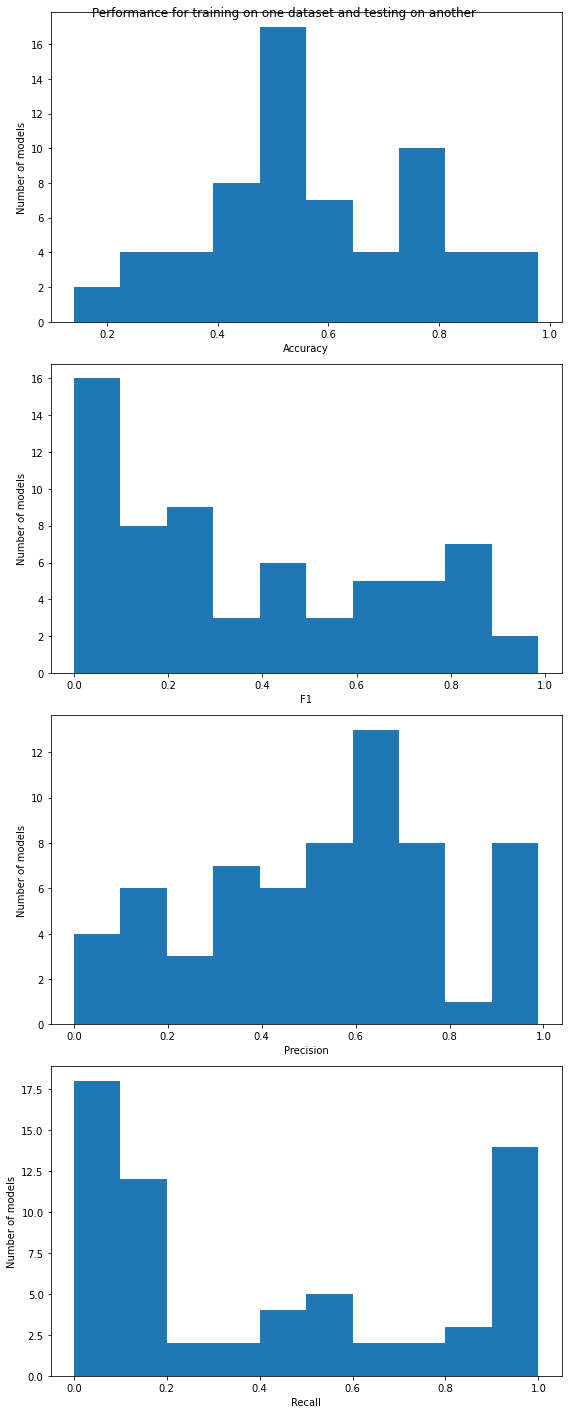

In [269]:
def hist_train_on_one_test_on_another(performance_df):
    fig, axes = plt.subplots(4, 1, figsize=(8,20))
    max_depth = 5

    accs = []
    fs = []
    precs = []
    recs = []


    for ind, row in performance_df.iterrows():
        metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
        accs.append(max(metric_a))

        metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
        fs.append(max(metric_f))


        metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
        precs.append(max(metric_p))


        metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
        recs.append(max(metric_r))


    axes[0].hist(accs)
    axes[1].hist(fs)
    axes[2].hist(precs)
    axes[3].hist(recs)


    axes[0].set_xlabel("Accuracy")
    axes[1].set_xlabel("F1")
    axes[2].set_xlabel("Precision")
    axes[3].set_xlabel("Recall")

    axes[0].set_ylabel("Number of models")
    axes[1].set_ylabel("Number of models")
    axes[2].set_ylabel("Number of models")
    axes[3].set_ylabel("Number of models")

    #axes[0].legend(loc='lower left')
    fig.suptitle("Performance for training on one dataset and testing on another")
    fig.tight_layout()
    plt.show()
    
hist_train_on_one_test_on_another(train_on_one_test_on_another_performance)

# Leave-one-dataset-out

In [89]:
cols = list(set.intersection(*map(set,[list(d) for d in datasets])))
max_depth = 5

def leave_dataset_out(i):
    
    use_datasets = datasets[:i] + datasets[i+1:]
    use_labels = labels[:i] + labels[i+1:]

    scores = {
        'left_out': get_dataset_name(datasets[i])
    }
    
    train_on = pd.concat([d[cols] for d in use_datasets])
    train_on_labels = pd.concat([pd.Series(d) for d in use_labels])
        
    test_on = datasets[i][cols]
    test_on_labels = labels[i]
    
    for j in range(1,max_depth+1):
        clf, *_ = fit_and_score(train_on[cols], train_on_labels, depth=j, silent=True)
        a,p,r,f = (score(clf, test_on[cols], test_on_labels, silent=True))
        scores = {
            **scores, 
            f'a{j}': a,
            f'p{j}': p,
            f'r{j}': r,
            f'f{j}': f
        }
    return scores


In [80]:
rows = []

for i in range(len(datasets)):
    rows.append(leave_dataset_out(i))
    
leave_one_out_scores = pd.DataFrame(rows)

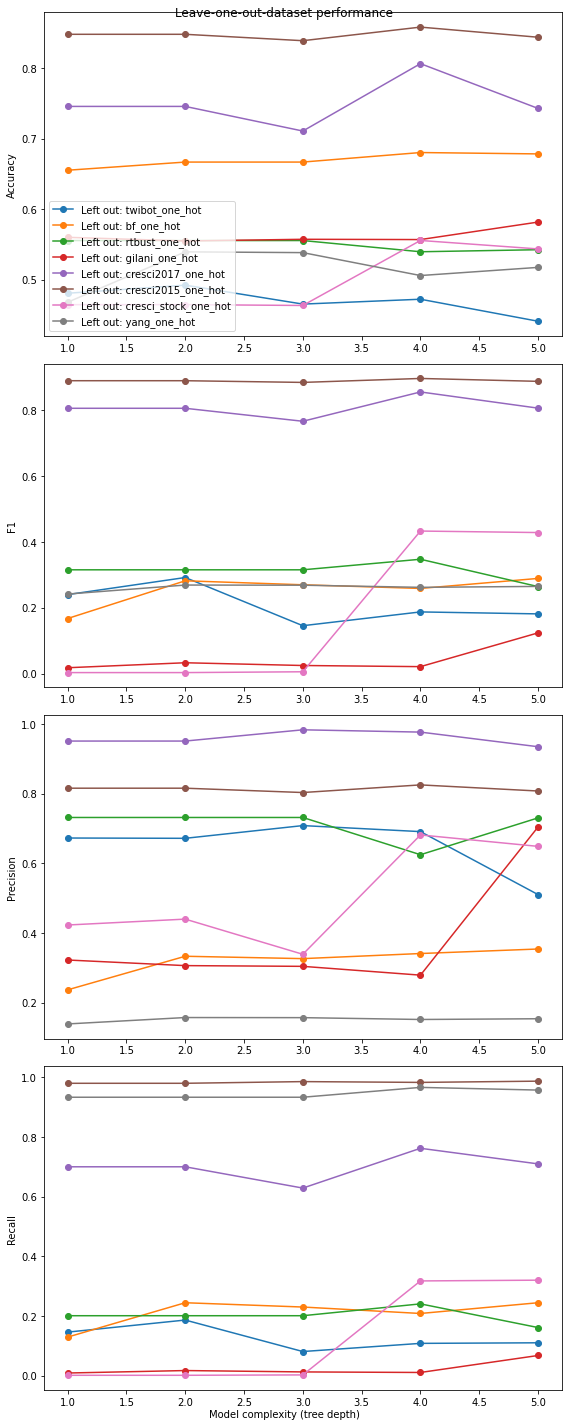

In [200]:
fig, axes = plt.subplots(4, 1, figsize=(8,20))
max_depth = 5

for ind, row in leave_one_out_scores.iterrows():
    metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
    axes[0].plot(range(1,6), metric_a, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
    axes[1].plot(range(1,6), metric_f, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
    axes[2].plot(range(1,6), metric_p, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
    axes[3].plot(range(1,6), metric_r, label=f"Left out: {row['left_out']}", marker="o")
    
    
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("F1")
    axes[2].set_ylabel("Precision")
    axes[3].set_ylabel("Recall")

axes[0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
fig.suptitle("Leave-one-out-dataset performance")
fig.tight_layout()
plt.show()

# Single-class datasets

In [93]:
# bot-wiki
botwiki_df, botwiki_one_hot, botwiki_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botwiki-2019_tweets.json", PROJ_PATH + "/data/botwiki-2019.tsv")
# celebrity
celebrity_df, celebrity_one_hot, celebrity_labels = load_bot_repo_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/celebrity-2019.tsv")
# political-bots
political_bots_df, political_bots_one_hot, political_bots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/political-bots-2019/political-bots-2019_tweets.json", PROJ_PATH + "/data/political-bots-2019/political-bots-2019.tsv")
# pronbots
pronbots_df, pronbots_one_hot, pronbots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/pronbots-2019.tsv")
# vendor purchased
vendor_purchased_df, vendor_purchased_one_hot, vendor_purchased_labels = load_bot_repo_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/vendor-purchased-2019.tsv")
# EMD
emd, emd_labels = load_emd(PROJ_PATH + '/data/EMD-2017/Twitter_dataset.arff') # Load data

## Analysis of each of the specialized classifiers in Botometer

### humans

In [282]:
caverlee2011.set_axis(['created_at', 'friends_count', 'followers_count', 'statuses_count', 'LengthfScreenName', 'LengthOfDescriptionInUserProfile'], inplace=True, axis=1)

caverlee2011_humans = caverlee2011.iloc[1 - caverlee2011_labels.values]
bf_one_hot_humans = bf_one_hot.iloc[1- bf_labels.values]
gilani_one_hot_humans = gilani_one_hot.iloc[1-gilani_labels.values]
rtbust_one_hot_humans = rtbust_one_hot.iloc[1-rtbust_labels.values]
cresci_stock_one_hot_humans = cresci_stock_one_hot.iloc[1-cresci_stock_labels.values]
midterm_one_hot_humans = midterm_one_hot.iloc[1-midterm_labels.values]

cols = set.intersection(
    set(celebrity_one_hot.columns),
    set(bf_one_hot_humans.columns),
    set(caverlee2011_humans.columns),
    set(gilani_one_hot_humans.columns),
    set(cresci_stock_one_hot_humans.columns),
                       )

human_df = pd.concat([
    caverlee2011_humans[cols], 
    bf_one_hot_humans[cols],
    celebrity_one_hot[cols],
    gilani_one_hot_humans[cols],
    cresci_stock_one_hot_humans[cols],
    celebrity_one_hot[cols]
], axis=0)

### simple bots

In [283]:
caverlee2011_bots = caverlee2011.iloc[caverlee2011_labels.values]
simple_df = caverlee2011_bots

### spammers

In [284]:
# Load in cresci data
folder_names = [ 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
is_bot = [1, 1, 1, 1, 1, 1, 1]
cols_to_drop = COLUMNS_TO_DROP + ['profile_banner_url', 
                                        'test_set_1', 
                                        'test_set_2', 
                                        'crawled_at',
                                        'updated', 
                                        'timestamp',
                                        'following', 
                                        'follow_request_sent',
                                        'created_at'
                                  ]
dummy_cols = DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications']
    
cresci2017_spammers, cresci2017_spammers_one_hot, cresci2017_spammers_labels  = load_cresci(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv", folder_names, is_bot, cols_to_drop, dummy_cols, False)
cresci2017_spammers_one_hot.loc[:,~cresci2017_spammers_one_hot.columns.duplicated()]

cols = pronbots_one_hot.columns.drop(['created_at', 'withheld_in_countries'])
spammers_df = pd.concat([pronbots_one_hot, cresci2017_spammers_one_hot[cols]])

### fake followers

In [285]:
# Load in cresci data
folder_names = ['fake_followers']
is_bot = [1]
cols_to_drop = COLUMNS_TO_DROP + ['profile_banner_url',  
                                        'updated', 
                                        'following', 
                                        'follow_request_sent',
                                        'created_at'
                                  ]
dummy_cols = DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications']
    
cresci2017_fake_followers, cresci2017_fake_followers_one_hot, cresci2017_fake_followers_labels  = load_cresci(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv", folder_names, is_bot, cols_to_drop, dummy_cols, False)
cresci2017_fake_followers_one_hot = cresci2017_fake_followers_one_hot.loc[:,~cresci2017_fake_followers_one_hot.columns.duplicated()]
vendor_purchased_one_hot = vendor_purchased_one_hot.loc[:,~vendor_purchased_one_hot.columns.duplicated()]

cols = set(vendor_purchased_one_hot.columns).intersection(set(cresci2017_fake_followers_one_hot.columns))
fake_followers_df = pd.concat([vendor_purchased_one_hot, cresci2017_fake_followers_one_hot[cols]])


### self-declared

In [286]:
self_declared_df = botwiki_one_hot

### political bots

In [287]:
political_bots_df = political_bots_one_hot

### other bots

In [288]:
bf_one_hot_bot = bf_one_hot.iloc[bf_labels.values]
gilani_one_hot_bot = gilani_one_hot.iloc[gilani_labels.values]
rtbust_one_hot_bot = rtbust_one_hot.iloc[rtbust_labels.values]
cresci_stock_one_hot_bot = cresci_stock_one_hot.iloc[cresci_stock_labels.values]
midterm_one_hot_bot = midterm_one_hot.iloc[midterm_labels.values]

cols = set.intersection(
    set(bf_one_hot_bot.columns), 
    set(gilani_one_hot_bot.columns), 
    set(rtbust_one_hot_bot.columns), 
    set(cresci_stock_one_hot_bot.columns), 
)

other_bots = pd.concat([bf_one_hot_bot[cols], 
                        gilani_one_hot_bot[cols], 
                        rtbust_one_hot_bot[cols], 
                        cresci_stock_one_hot_bot[cols]])


# Botometer combined datasets: train on one, test on same one

In [340]:
def train_test_botometer_combined(bots, humans, silent=True):
    dataset_size = min(len(bots), len(humans))
    bot_inds = np.random.permutation(dataset_size)
    human_inds = np.random.permutation(dataset_size)
    
    cols = set.intersection(
        set(bots.columns),
        set(humans.columns)
    )
    cols.remove('created_at')
    
    X = pd.concat([bots.iloc[bot_inds][cols], humans.iloc[human_inds][cols]])
    y = [1] * dataset_size + [0] * dataset_size
        
    X = X.fillna(0)
    
    
    scores = {
        'dataset': get_dataset_name(bots),
    }
    
    for i in range(1, max_depth+1):
        a,p,r,f = train_test_fit_and_score(X, y, depth=i, silent=silent)
        #prop_bots = sum(test_on_labels)/len(test_on_labels)
        scores = {
            **scores, 
            f'a{i}': a,
            f'p{i}': p,
            f'r{i}': r,
            f'f{i}': f
        }
        
    return scores
        

In [341]:
botometer_datasets = [simple_df, spammers_df, fake_followers_df, self_declared_df, political_bots_df, other_bots]
rows = []
for j, dataset in enumerate(botometer_datasets):
    rows.append(train_test_botometer_combined(dataset, human_df, silent=True))
    
botometer_leave_one_out_scores = pd.DataFrame(rows)

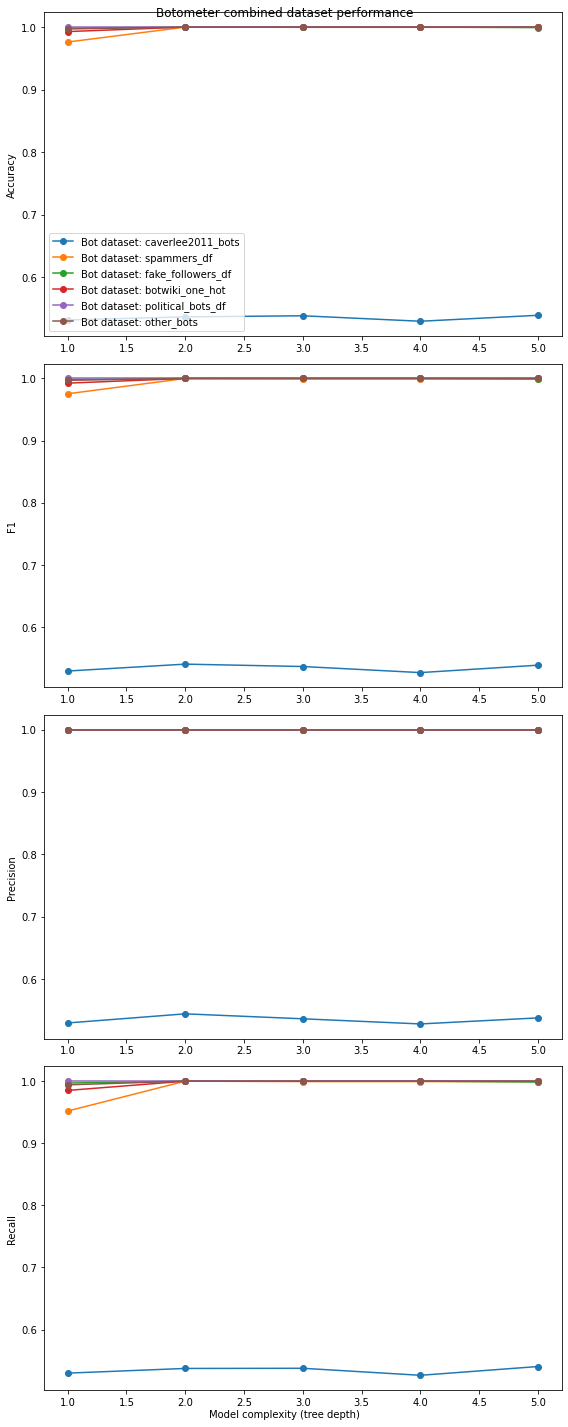

In [342]:
fig, axes = plt.subplots(4, 1, figsize=(8,20))
max_depth = 5

for ind, row in botometer_leave_one_out_scores.iterrows():
    metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
    axes[0].plot(range(1,6), metric_a, label=f"Bot dataset: {row['dataset']}", marker="o")
    
    metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
    axes[1].plot(range(1,6), metric_f, label=f"{row['dataset']}", marker="o")
    
    metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
    axes[2].plot(range(1,6), metric_p, label=f"{row['dataset']}", marker="o")
    
    metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
    axes[3].plot(range(1,6), metric_r, label=f"{row['dataset']}", marker="o")
    
    
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("F1")
    axes[2].set_ylabel("Precision")
    axes[3].set_ylabel("Recall")

axes[0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
fig.suptitle("Botometer combined dataset performance")
fig.tight_layout()
plt.show()

# Botometer combined datasets: train on one, test on another

In [311]:
def train_on_one_test_on_another_botometer_combined(bots1, bots2, humans, silent=True):
    dataset_size = min(len(bots1), len(bots2), len(humans))
    bot1_inds = np.random.permutation(dataset_size)
    human1_inds = np.random.permutation(dataset_size)
    
    bot2_inds = np.random.permutation(dataset_size)
    human2_inds = np.random.permutation(dataset_size)
    
    cols = set.intersection(
        set(bots1.columns),
        set(bots2.columns),
        set(humans.columns)
    )
    if 'created_at' in cols:
        cols.remove('created_at')
    
    train_on = pd.concat([bots1.iloc[bot1_inds][cols], humans.iloc[human1_inds][cols]])
    train_on_labels = [1] * dataset_size + [0] * dataset_size
    train_on = train_on[cols].fillna(0)
    
    test_on = pd.concat([bots2.iloc[bot2_inds][cols], humans.iloc[human2_inds][cols]])
    test_on_labels = [1] * dataset_size + [0] * dataset_size
    test_on = test_on[cols].fillna(0)
    
    
    scores = {
        'train_on': get_dataset_name(bots1),
        'test_on': get_dataset_name(bots2),
    }
    
    for i in range(1, max_depth+1):
        clf, *_ = fit_and_score(train_on, train_on_labels, depth=i, silent=silent)
        a,p,r,f = score(clf, test_on, test_on_labels, silent=silent)
        #prop_bots = sum(test_on_labels)/len(test_on_labels)
        scores = {
            **scores, 
            f'a{i}': a,
            f'p{i}': p,
            f'r{i}': r,
            f'f{i}': f
        }
        
    return scores


In [316]:
rows = []

for bots1 in botometer_datasets:
    for bots2 in botometer_datasets:
        if (get_dataset_name(bots1) == get_dataset_name(bots2)):
            continue
        #print(get_dataset_name(bots1), get_dataset_name(bots2))
        rows.append(train_on_one_test_on_another_botometer_combined(bots1, bots2, human_df, silent=True))
        
botometer_train_on_one_test_on_another_performance = pd.DataFrame(rows)   


/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


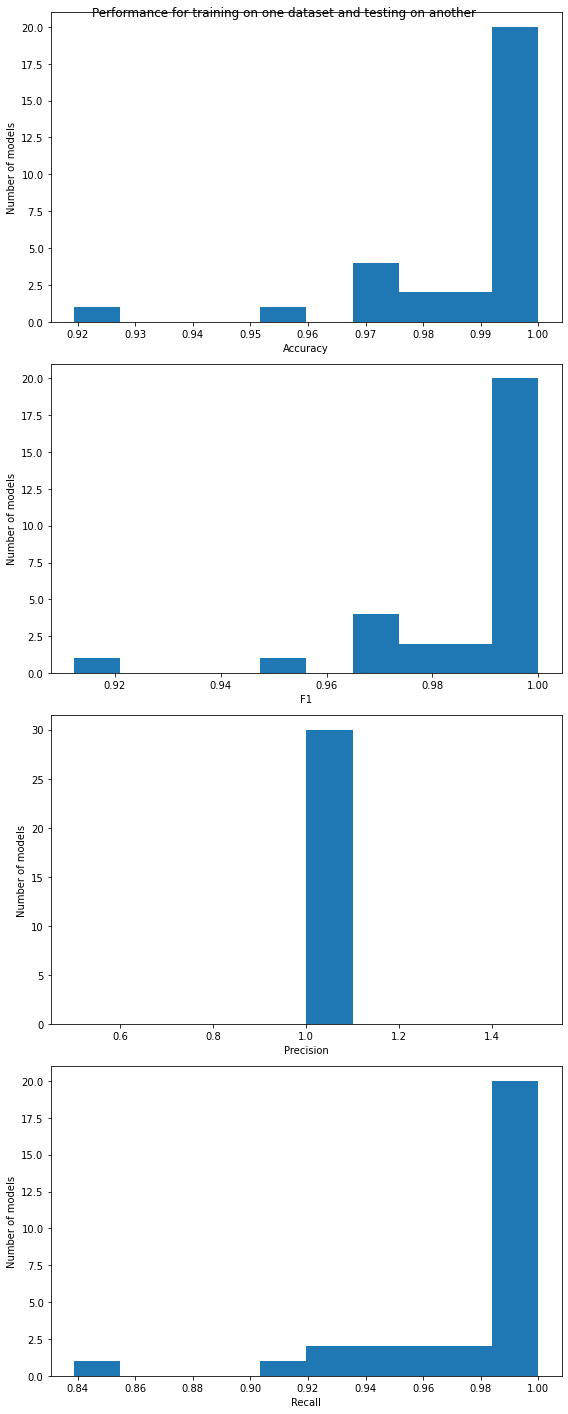

In [313]:
hist_train_on_one_test_on_another(botometer_train_on_one_test_on_another_performance)

# Botometer combined datasets: leave-one-dataset-out

In [329]:
cols = list(set.intersection(*map(set,[list(d) for d in botometer_datasets])))
max_depth = 5

def botometer_leave_dataset_out(datasets, i):
    
    use_datasets = datasets[:i] + datasets[i+1:]
    num_bots = sum([len(d) for d in datasets[:i]]) + sum([len(d) for d in datasets[i+1:]])
    
    dataset_size = min(num_bots, len(datasets[i]), len(human_df))
    
    bot_train_inds = np.random.permutation(dataset_size)
    human_train_inds = np.random.permutation(dataset_size)
    
    bot_test_inds = np.random.permutation(dataset_size)
    human_test_inds = np.random.permutation(dataset_size)
    

    scores = {
        'left_out': get_dataset_name(datasets[i])
    }
    
    train_on_bots = pd.concat([d[cols] for d in use_datasets]).iloc[bot_train_inds]
    train_on = pd.concat([train_on_bots, human_df.iloc[human_train_inds][cols]])
    train_on_labels = [1]*dataset_size + [0]*dataset_size
    train_on = train_on.fillna(0)

        
    test_on_bots = datasets[i][cols].iloc[bot_test_inds]
    test_on = pd.concat([test_on_bots, human_df.iloc[human_test_inds][cols]])
    test_on_labels = [1]*dataset_size + [0]*dataset_size
    test_on = test_on.fillna(0)

    
    for j in range(1,max_depth+1):
        clf, *_ = fit_and_score(train_on, train_on_labels, depth=j, silent=True)
        a,p,r,f = (score(clf, test_on, test_on_labels, silent=True))
        scores = {
            **scores, 
            f'a{j}': a,
            f'p{j}': p,
            f'r{j}': r,
            f'f{j}': f
        }
    return scores


In [330]:
rows = []

for i in range(len(botometer_datasets)):
    rows.append(botometer_leave_dataset_out(botometer_datasets, i))
    
botometer_leave_one_out_scores = pd.DataFrame(rows)

/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

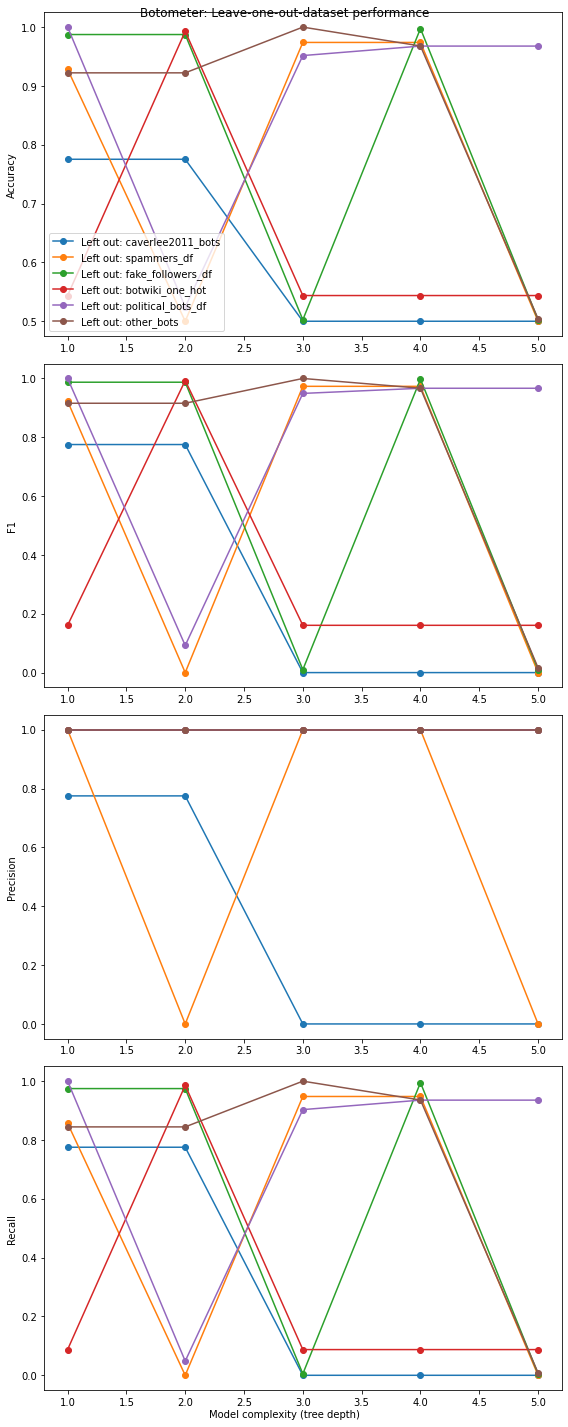

In [332]:
fig, axes = plt.subplots(4, 1, figsize=(8,20))
max_depth = 5

for ind, row in botometer_leave_one_out_scores.iterrows():
    metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
    axes[0].plot(range(1,6), metric_a, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
    axes[1].plot(range(1,6), metric_f, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
    axes[2].plot(range(1,6), metric_p, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
    axes[3].plot(range(1,6), metric_r, label=f"Left out: {row['left_out']}", marker="o")
    
    
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("F1")
    axes[2].set_ylabel("Precision")
    axes[3].set_ylabel("Recall")

axes[0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
fig.suptitle("Botometer: Leave-one-out-dataset performance")
fig.tight_layout()
plt.show()

# Plotting performance of network stats on single plot

In [66]:
scores_dict = {
    "twibot": {
        'c': 'C0',
        "a": 0.8664, #accuracy
        "p": 0.8256, #precision
        "r": 0.8657, #recall
        'scores': twibot_scores
    },
    "botometer-feedback-2019": {
        'c': 'C1',
        'a': 0.81,
        "p": 0.84,
        "r": 0.7,
        'num_bots': 139,
        'num_humans': 380,
        'scores': botometer_feedback_scores
    },
    "rtbust": {
        'c': 'C2',        
        "a": 0.8755,
        'p': 0.9304,
        'r': 0.9512,
        'scores': rtbust_scores
    },
    "midterm-2018": {
        'c': 'C3',
        "a": 0.987,
        'p': 0.989,
        'r': 0.995,
        'scores': midterm_scores
    },
    "gilani": {
        'c': 'C4',
        "a": 0.8644,
        'p': 0.854,
        'r': 0.822,
        'scores': gilani_derived_scores_avg
    },
    "cresci-2017": {
        'c': 'C5',
        'a': 0.9871,
        'p': 0.98,
        'r': 0.98,
        'scores': cresci2017_scores
    },
    "cresci-2015": {
        'c': 'C6',
        "a": 0.991,
        'p': 0.994,
        'r': 0.991,
        'scores': cresci2015_scores
    },
    "caverlee-2011": {
        'c': 'C6',
        'a': 0.9826,
        'p': 0.89,
        'r': 0.87,
        'num_bots': 19276,
        'num_humans': 22223,
        'scores': caverlee2011_scores
    },
    'pan19': {
        'c': 'C7',
        'f': 0.95,
        'a': 0.95,
        'scores': pan19_scores
    },
    'cresci-2017 tweets': {
        'c': 'C8',
        'a': 0.976,
        'p': 1,
        'r': 0.95,
        'scores': pan19_scores
    },
    'yang-2013': {
        'c': 'C9',
        'a': 0.98,
        'p': 0.96,
        'r': 0.85,
        'scores': yang_scores
    }
}
metric_names = ['accuracy', 'F1', 'precision', 'recall']

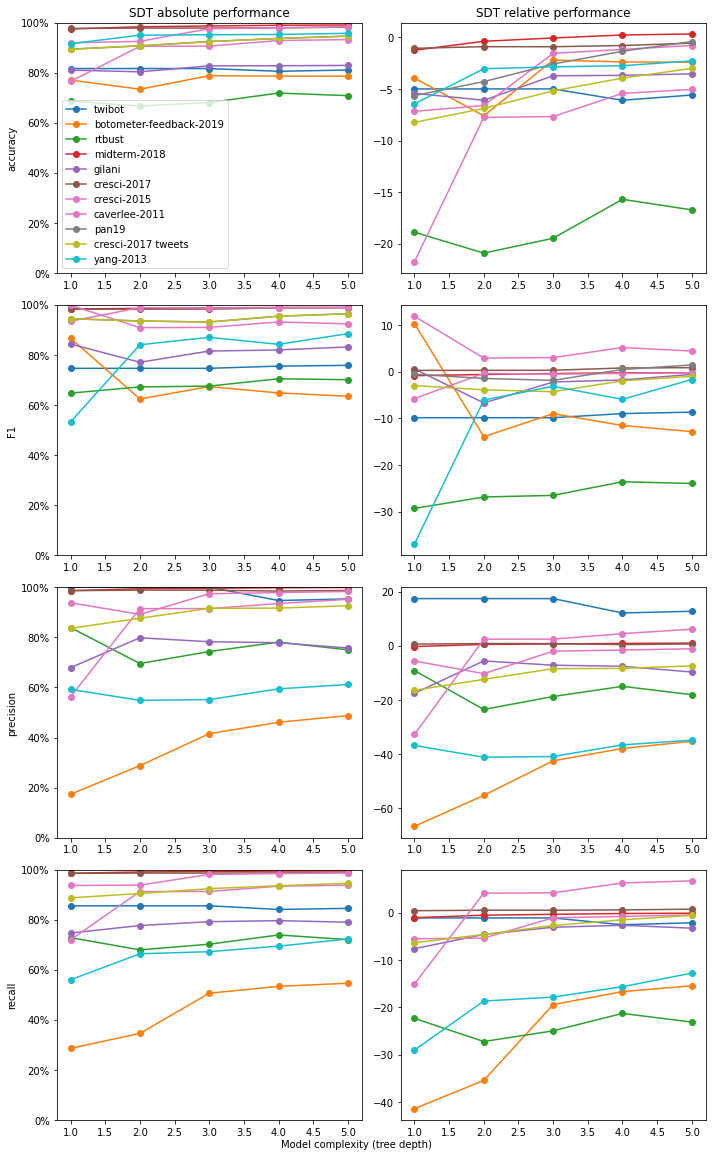

In [67]:
fig, axes = plt.subplots(4,2, figsize=(10, 16))

for i, metric_name in enumerate(metric_names):
    for name, d in scores_dict.items():
        if i == 0:
            if 'a' not in d:
                continue
            soa_score = d['a']
        if i == 1:
            if 'f' not in d:
                d['f'] = 2 * (d['p'] * d['r']) / (d['p'] + d['r'])
            soa_score = d['f']
        if i == 2:
            if 'p' not in d:
                continue
            soa_score = d['p']
        if i == 3:
            if 'r' not in d:
                continue
            soa_score = d['r']
        metric_i = [item[i]*100 for item in d['scores']]
        axes[i][0].plot(range(1,6), metric_i, label=name, marker="o", color=d['c'])
        metric_i_relative = [(item[i]-soa_score)*100 for item in d['scores']]
        axes[i][1].plot(range(1,6), metric_i_relative, label=name, marker="o", color=d['c'])
        metric_i_max = max([item[i] for item in d['scores']])
        delta_i = metric_i_max - soa_score
        d["sdt_"+metric_name] = metric_i_max
        d["sdt_delta_"+metric_name] = delta_i
    axes[i][0].set_ylabel(metric_name)
    axes[i][0].set_ylim((0,100))
    yticks = mtick.PercentFormatter(is_latex=True)
    axes[i][0].yaxis.set_major_formatter(yticks)
axes[0][0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
axes[0][0].set_title("SDT absolute performance")
axes[0][1].set_title("SDT relative performance")
fig.tight_layout()
plt.show()

score_df = pd.DataFrame.from_dict(scores_dict, orient="index")
score_df.to_csv("bot_detection_scores.csv")

In [12]:
score_df

,Unnamed: 0,c,a,p,r,scores,sdt_accuracy,sdt_delta_accuracy,f,sdt_F1,sdt_delta_F1,sdt_precision,sdt_delta_precision,sdt_recall,sdt_delta_recall,num_bots,num_humans
0,twibot,C0,0.8664,0.8256,0.8657,"[(0.8165680473372781, 0.7467911318553092, 1.0,...",0.816568,-0.049832,0.845175,0.758706,-0.086468,1.000000,0.174400,0.855043,-0.010657,NaN,NaN
1,botometer-feedback-2019,C1,0.8100,0.8400,0.7000,"[[0.7706870799103809, 0.8666666666666668, 0.17...",0.788107,-0.021893,0.763636,0.866667,0.103030,0.487398,-0.352602,0.545837,-0.154163,139.0,380.0
2,rtbust,C2,0.8755,0.9304,0.9512,"[[0.6868245549545764, 0.6478865844428551, 0.83...",0.718689,-0.156811,0.940685,0.705060,-0.235625,0.838990,-0.091410,0.738596,-0.212604,NaN,NaN
3,midterm-2018,C3,0.9870,0.9890,0.9950,"[[0.9746726057177378, 0.9836441297945695, 0.98...",0.990403,0.003403,0.991991,0.989754,-0.002237,0.998916,0.009916,0.994313,-0.000687,NaN,NaN
4,gilani,C4,0.8644,0.8540,0.8220,"[[0.8102938901094743, 0.8438062934029893, 0.67...",0.829171,-0.035229,0.837695,0.843806,0.006112,0.798058,-0.055942,0.795779,-0.026221,NaN,NaN
5,cresci-2017,C5,0.9871,0.9800,0.9800,"[[0.9766149495137464, 0.9830057669465452, 0.98...",0.981626,-0.005474,0.980000,0.988776,0.008776,0.988345,0.008345,0.987866,0.007866,NaN,NaN
6,cresci-2015,C6,0.9910,0.9940,0.9910,"[[0.9194528287249761, 0.9351086925652069, 0.93...",0.983212,-0.007788,0.992498,0.990368,-0.002130,0.983016,-0.010984,0.986659,-0.004341,NaN,NaN
7,caverlee-2011,C6,0.9826,0.8900,0.8700,"[[0.7653196567448248, 0.9987098953890051, 0.56...",0.932287,-0.050313,0.879886,0.998710,0.118824,0.951527,0.061527,0.937694,0.067694,19276.0,22223.0
8,pan19,C7,0.9500,NaN,NaN,"[[0.8937117516629712, 0.9448299344960379, 0.83...",0.946103,-0.003897,0.950000,0.964633,0.014633,NaN,NaN,NaN,NaN,NaN,NaN
9,cresci-2017 tweets,C8,0.9760,1.0000,0.9500,"[[0.8937117516629712, 0.9448299344960379, 0.83...",0.946103,-0.029897,0.974359,0.964633,-0.009726,0.926033,-0.073967,0.944890,-0.005110,NaN,NaN


In [2]:
score_df = pd.read_csv('bot_detection_scores.csv')

In [25]:
score_df[['Unnamed: 0', 'sdt_delta_F1']]

,Unnamed: 0,sdt_delta_F1
0,twibot,-0.086468
1,botometer-feedback-2019,0.103030
2,rtbust,-0.235625
3,midterm-2018,-0.002237
4,gilani,0.006112
5,cresci-2017,0.008776
6,cresci-2015,-0.002130
7,caverlee-2011,0.118824
8,pan19,0.014633
9,cresci-2017 tweets,-0.009726


In [74]:
score_df['sdt_delta_F1']

twibot                    -0.086468
botometer-feedback-2019    0.103030
rtbust                    -0.235625
midterm-2018              -0.002237
gilani                     0.006112
cresci-2017                0.008776
cresci-2015               -0.002130
caverlee-2011              0.118824
pan19                      0.014633
cresci-2017 tweets        -0.009726
yang-2013                 -0.016615
Name: sdt_delta_F1, dtype: float64